In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(modelr)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.1          ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.1          ✔ tidyr     1.3.0     
── Conf

In [2]:
zm_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"


#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
zm_input <- here(zm_working_dir,"00.data/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt")
#input_2 <- here("/home/juf73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
zm_meta <- here(zm_working_dir,"00.data/Zm.leaf_annot.V5.meta.frozen.txt")
zm_gene <- here(zm_working_dir,"00.data/Zm.markers.leaf.txt")
zm_gene_DA <- here(zm_working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

zm_meta_data <- read.delim(zm_meta)
zm_gene_markers <- read.delim(zm_gene)
zm_gene_markers <- zm_gene_markers  %>%
    arrange(type)

zm_all_markers <- zm_gene_markers$geneID

zm_raw_cuf_counts_all_genes <- read_delim(zm_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

zm_merged_meta_cuf_information <- left_join(zm_meta_data, zm_raw_cuf_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(final_annotation, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt Cuf Calc
zm_merged_meta_cuf_information_copied <- zm_merged_meta_cuf_information
zm_catch <- zm_merged_meta_cuf_information_copied  %>%
    group_by(final_annotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



zm_caught_values <- as_tibble(zm_catch)
zm_see <- ungroup(zm_merged_meta_cuf_information_copied)
zm_merged_meta_cuf_information_copied<- bind_cols(zm_merged_meta_cuf_information_copied,zm_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Zm")  %>% 
    group_by(final_annotation) %>%  
    mutate(log_cuf  = log(grouped_CPM))


#Apply quantile normalization
zm_merged_meta.quant_norm <- zm_merged_meta_cuf_information_copied  %>% 
        group_by(final_annotation)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(zm_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cuf" = value)


zm_merged_meta_cuf_information_copied <- bind_cols(zm_merged_meta_cuf_information_copied, zm.quantile_normalized)


Rows: 22253352 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'final_annotation'. You can override using the `.groups` argument.


In [3]:

uf_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/urochloa_fusca/"


uf_input <- here(uf_working_dir,"urochloa_fusca.gene_body_acc_leaf_clustering.counts.txt")
uf_meta <- here(uf_working_dir, "uf.leaf_annotation.V1.meta.txt")

uf_gene <- here(uf_working_dir,"Uf.combined_known_de_novo_markers.visualize.txt")
uf_gene_DA <- here(uf_working_dir,"Ufusca_669_v1.1.gene_only.bed")
#prefix <- "TEST_SORGHUM_TEST"

uf_meta_data <- read.delim(uf_meta)
uf_gene_markers <- read.delim(uf_gene)
uf_gene_markers <- uf_gene_markers  %>%
    arrange(type)



all_markers <- uf_gene_markers$geneID
uf_raw_cuf_counts_all_genes <- read_delim(uf_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)


uf_merged_meta_cuf_information <- left_join(uf_meta_data, uf_raw_cuf_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(annotation_v1, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt Cuf Calc
uf_merged_meta_cuf_information_copied <- uf_merged_meta_cuf_information
uf_catch <- uf_merged_meta_cuf_information_copied  %>%
    group_by(annotation_v1) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()


uf_caught_values <- as_tibble(uf_catch)
uf_see <- ungroup(uf_merged_meta_cuf_information_copied)
uf_merged_meta_cuf_information_copied <- bind_cols(uf_merged_meta_cuf_information_copied,uf_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "uf")  %>% 
    group_by(annotation_v1) %>%  
    mutate(log_cuf  = log(grouped_CPM))

#Apply quantile normalization
uf_merged_meta.quant_norm <- uf_merged_meta_cuf_information_copied  %>% 
        group_by(annotation_v1)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

uf.quantile_normalized <- as_tibble(uf_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cuf" = value)

#Combine and re_name
uf_merged_meta_cuf_information_copied <- bind_cols(uf_merged_meta_cuf_information_copied, uf.quantile_normalized)



Rows: 73649352 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'annotation_v1'. You can override using the `.groups` argument.


In [4]:
uf.cell_type_accessability <- uf_merged_meta_cuf_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, annotation_v1, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cuf)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cuf, values_fill = 0)


zm.cell_type_accessability <- zm_merged_meta_cuf_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, final_annotation, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cuf)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cuf, values_fill = 0)
    

In [5]:
str(uf.cell_type_accessability)

tibble [35,430 × 5] (S3: tbl_df/tbl/data.frame)
 $ geneID                           : chr [1:35430] "Urofu.1G000100.v1.1" "Urofu.1G000200.v1.1" "Urofu.1G000300.v1.1" "Urofu.1G000400.v1.1" ...
 $ uf.bundle_sheath                 : num [1:35430] 5.15 106.9 104.94 17.32 11.15 ...
 $ uf.companion_cells_sieve_elements: num [1:35430] 3.8 161 203.3 30.2 15.4 ...
 $ uf.epidermis                     : num [1:35430] 91.91 263.92 96.18 23.47 9.27 ...
 $ uf.mesophyll                     : num [1:35430] 10.5 100.5 87.6 17.3 11.1 ...


In [6]:
Uf.Zm.key_file <- read_delim(here(uf_working_dir,"Uf.Zm_markers_all.key_file.txt"), 
                             col_names = c("uf", "zm", "gene_name", "cell_type", "tis"))  %>% 
        distinct()

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 251 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): uf, zm, gene_name, cell_type, tis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
str(Uf.Zm.key_file)

tibble [251 × 5] (S3: tbl_df/tbl/data.frame)
 $ uf       : chr [1:251] "Urofu.3G374800.v1.1" "Urofu.3G374700.v1.1" "Urofu.3G374800.v1.1" "Urofu.3G374700.v1.1" ...
 $ zm       : chr [1:251] "Zm00001eb408920" "Zm00001eb408920" "Zm00001eb408900" "Zm00001eb408900" ...
 $ gene_name: chr [1:251] "sweet13a" "sweet13a" "sweet13b" "sweet13b" ...
 $ cell_type: chr [1:251] "abaxial_bundle_sheath.phloem_parenchyma" "abaxial_bundle_sheath.phloem_parenchyma" "abaxial_bundle_sheath.phloem_parenchyma" "abaxial_bundle_sheath.phloem_parenchyma" ...
 $ tis      : chr [1:251] "leaf" "leaf" "leaf" "leaf" ...


In [8]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "fama_v4v5count_1", 
                      "dct2", "shr2h", "shr2", "gl1", "ZmAAP6_4", "bhlh43","ocl1",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "ZmSMXL5")

good_gene_markers <- Uf.Zm.key_file  %>% 
    filter(gene_name %in% good_marker_list)  %>% 
    select(-cell_type, -tis)



In [9]:
head(good_gene_markers)

uf,zm,gene_name
<chr>,<chr>,<chr>
Urofu.3G374800.v1.1,Zm00001eb408920,sweet13a
Urofu.3G374700.v1.1,Zm00001eb408920,sweet13a
Urofu.3G374800.v1.1,Zm00001eb408900,sweet13b
Urofu.3G374700.v1.1,Zm00001eb408900,sweet13b
Urofu.3G374800.v1.1,Zm00001eb133100,sweet13c
Urofu.3G374700.v1.1,Zm00001eb133100,sweet13c


In [10]:
final_combined_dataset <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    left_join(., uf.cell_type_accessability, by = c("uf" = "geneID"))  %>% 
    rowwise()  %>% 
    mutate(unique_count = n())

generate_corr_matrix <- final_combined_dataset  %>% 
    select(-uf, -zm, -gene_name, -unique_count)

generate_corr_matrix[is.na(generate_corr_matrix)] = 0

cell_type_corr_matrix <- cor(generate_corr_matrix)

In [11]:
cell_type_corr_matrix <- cor(generate_corr_matrix)

In [12]:
str(generate_corr_matrix)

rowws_df [54 × 12] (S3: rowwise_df/tbl_df/tbl/data.frame)
 $ Zm.bundle_sheath                 : num [1:54] 53.7 53.7 61.7 61.7 53.2 ...
 $ Zm.companion_cells               : num [1:54] 5.448 5.448 0.908 0.908 3.632 ...
 $ Zm.epidermis                     : num [1:54] 4.1 4.1 4.27 4.27 5.81 ...
 $ Zm.mesophyll                     : num [1:54] 2.01 2.01 2.58 2.58 1.86 ...
 $ Zm.mesophyll;developing          : num [1:54] 5.07 5.07 5.07 5.07 0 ...
 $ Zm.phloem_sieve_elements         : num [1:54] 8.21 8.21 5.93 5.93 2.74 ...
 $ Zm.procambial_meristem           : num [1:54] 148 148 124 124 83 ...
 $ Zm.protoderm                     : num [1:54] 4.3 4.3 8.09 8.09 7.08 ...
 $ uf.bundle_sheath                 : num [1:54] 4.9 9.95 4.9 9.95 4.9 ...
 $ uf.companion_cells_sieve_elements: num [1:54] 3.8 7.36 3.8 7.36 3.8 ...
 $ uf.epidermis                     : num [1:54] 1.08 7.37 1.08 7.37 1.08 ...
 $ uf.mesophyll                     : num [1:54] 1.67 4.49 1.67 4.49 1.67 ...
 - attr(*, "groups")

In [13]:
sum(is.na(generate_corr_matrix))

[1] 0

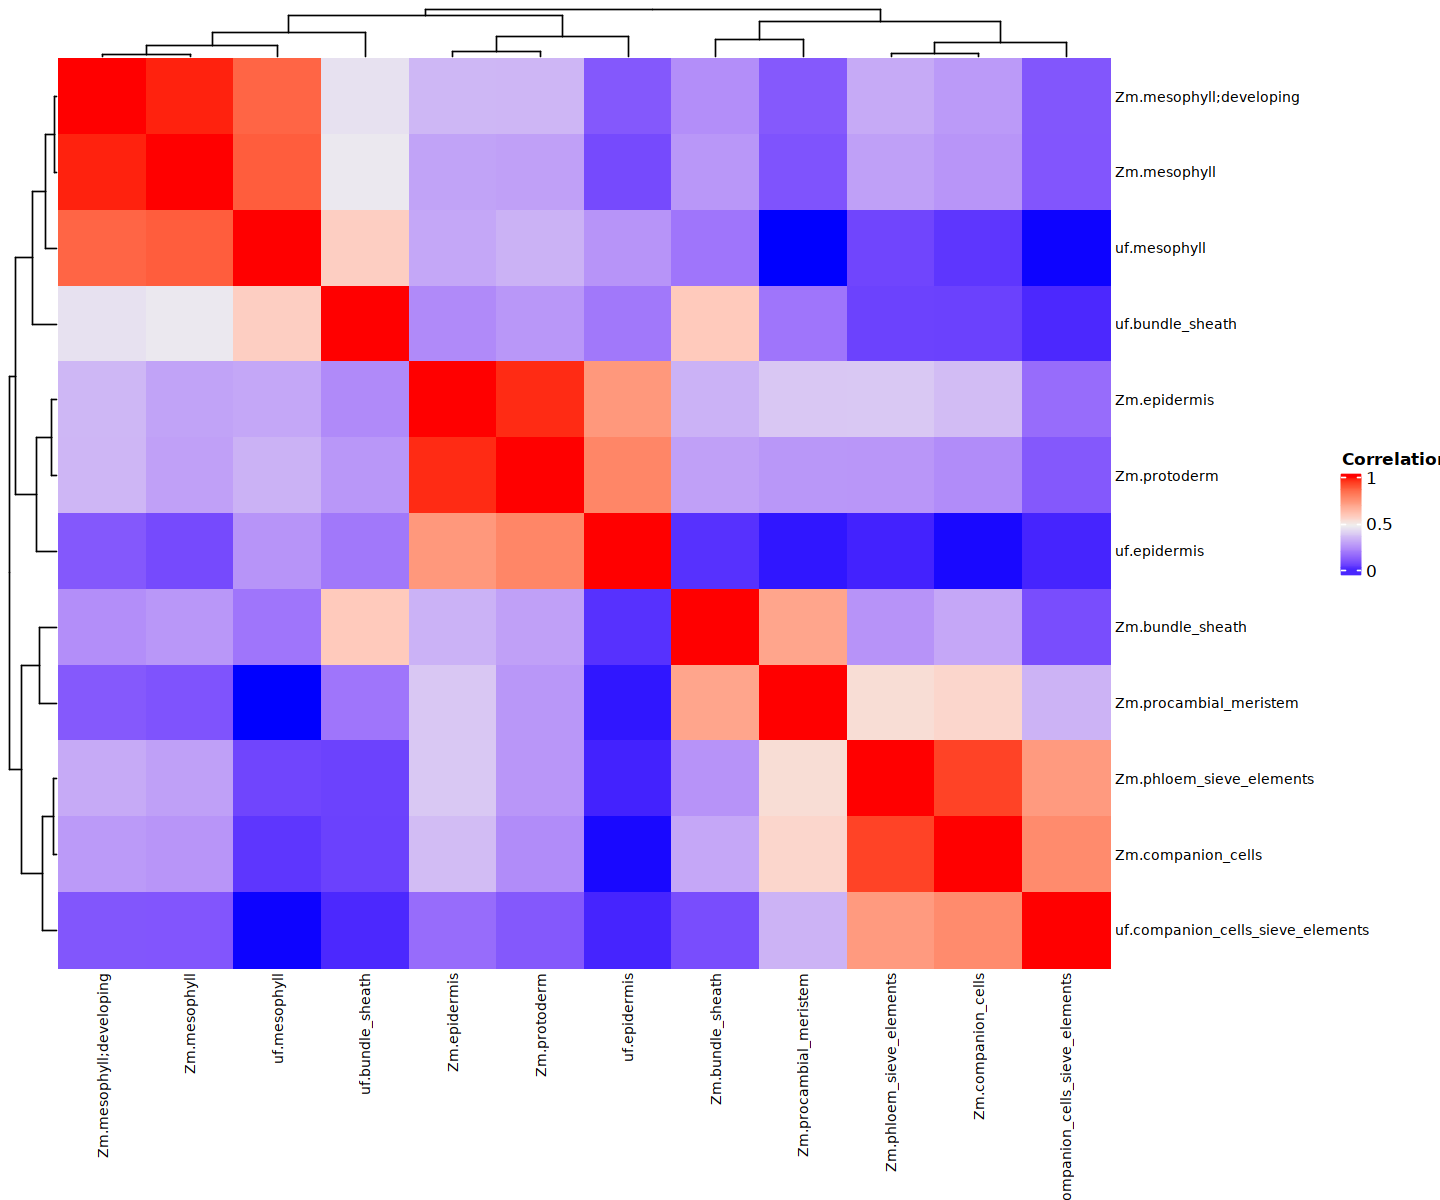

In [14]:
library(ComplexHeatmap)

options(repr.plot.width=12, repr.plot.height=10)
zm_vs_uf_all_vs_all_markers <- Heatmap(cell_type_corr_matrix,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

zm_vs_uf_all_vs_all_markers

In [15]:
zm.cell_types <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    select(-uf, -zm, -gene_name)
uf.cell_types <- left_join(good_gene_markers, uf.cell_type_accessability, by = c("uf" = "geneID"))  %>% 
    select(-uf, -zm, -gene_name)



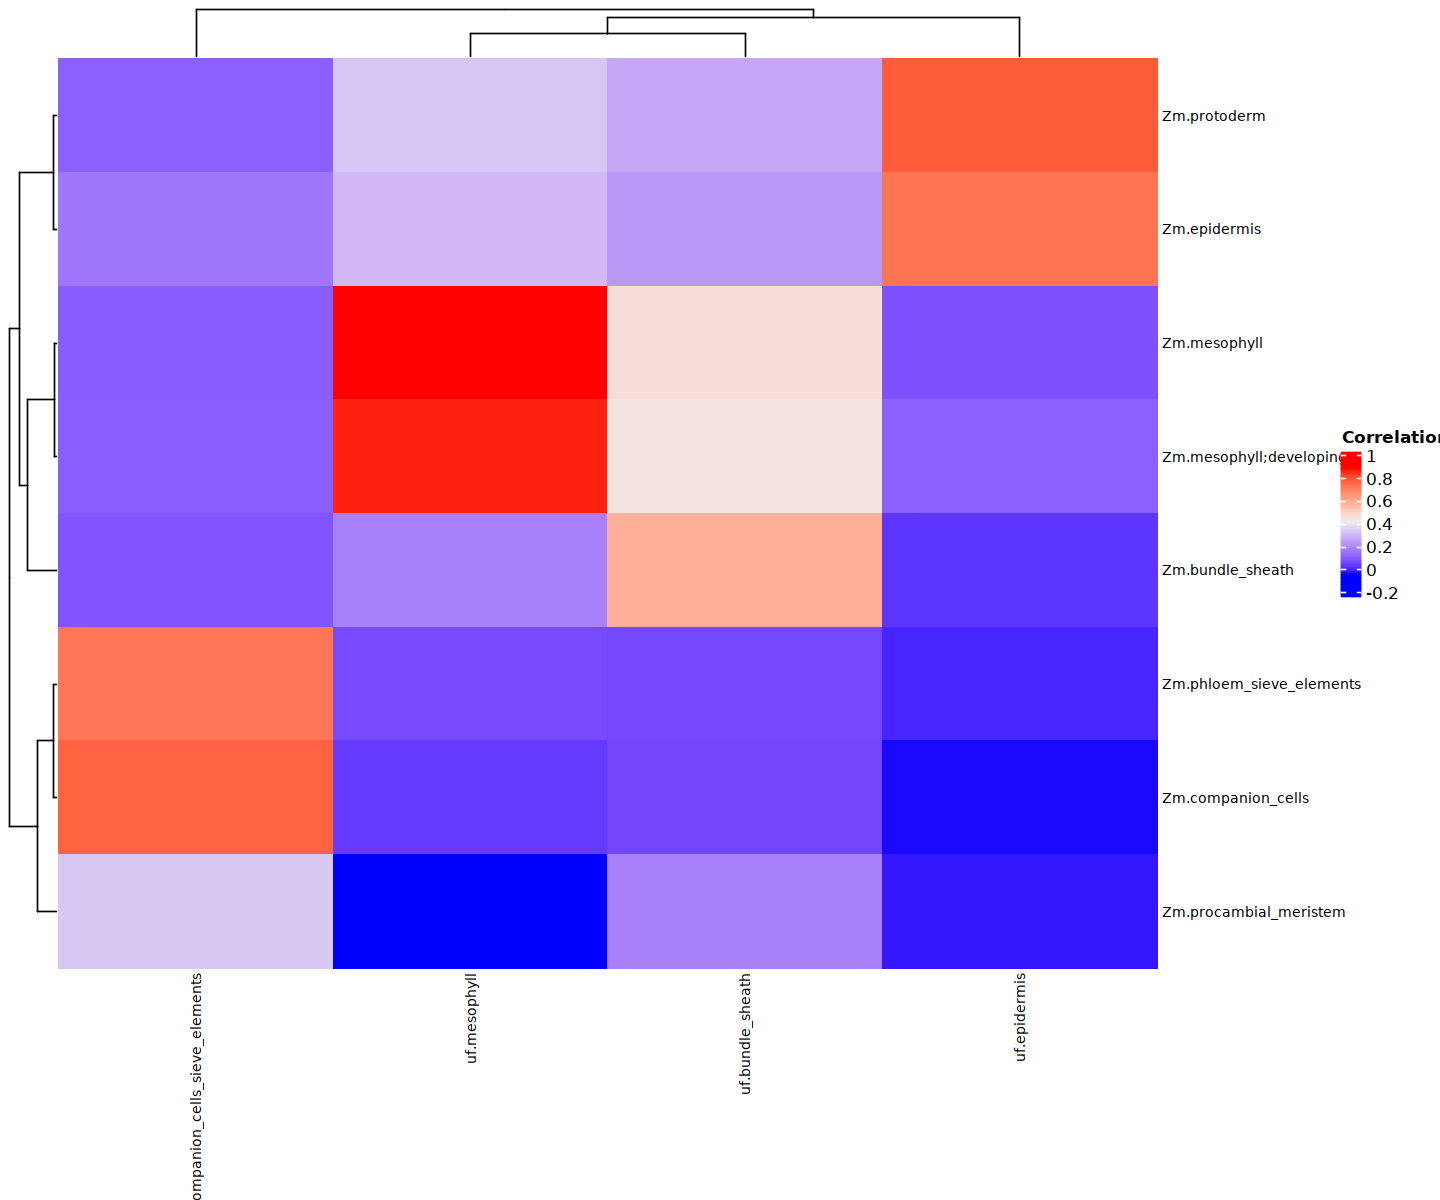

In [16]:



options(repr.plot.width=12, repr.plot.height=10)

zm.cell_types[is.na(zm.cell_types)] = 0
uf.cell_types[is.na(uf.cell_types)] = 0
sep_corr_matrix <- cor(zm.cell_types, uf.cell_types)
zm_vs_uf_markers <- Heatmap(sep_corr_matrix,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_uf_markers




In [17]:
sep_corr_matrix

,uf.bundle_sheath,uf.companion_cells_sieve_elements,uf.epidermis,uf.mesophyll
Zm.bundle_sheath,0.58528738,0.08261258,0.018844684,0.17888355
Zm.companion_cells,0.05327140,0.76755840,-0.040915294,0.02975969
Zm.epidermis,0.23095226,0.15639162,0.731467427,0.30261214
Zm.mesophyll,0.46252111,0.10157845,0.075374868,0.88291802
Zm.mesophyll;developing,0.44407480,0.10331260,0.107228624,0.86426575
Zm.phloem_sieve_elements,0.05589344,0.72511506,-0.008098827,0.06389198
Zm.procambial_meristem,0.17824972,0.33096060,-0.026638523,-0.04780302
Zm.protoderm,0.26321607,0.10660237,0.782083791,0.32968555


In [18]:
colnames(zm.cell_types.dropped)

ERROR: Error in is.data.frame(x): object 'zm.cell_types.dropped' not found


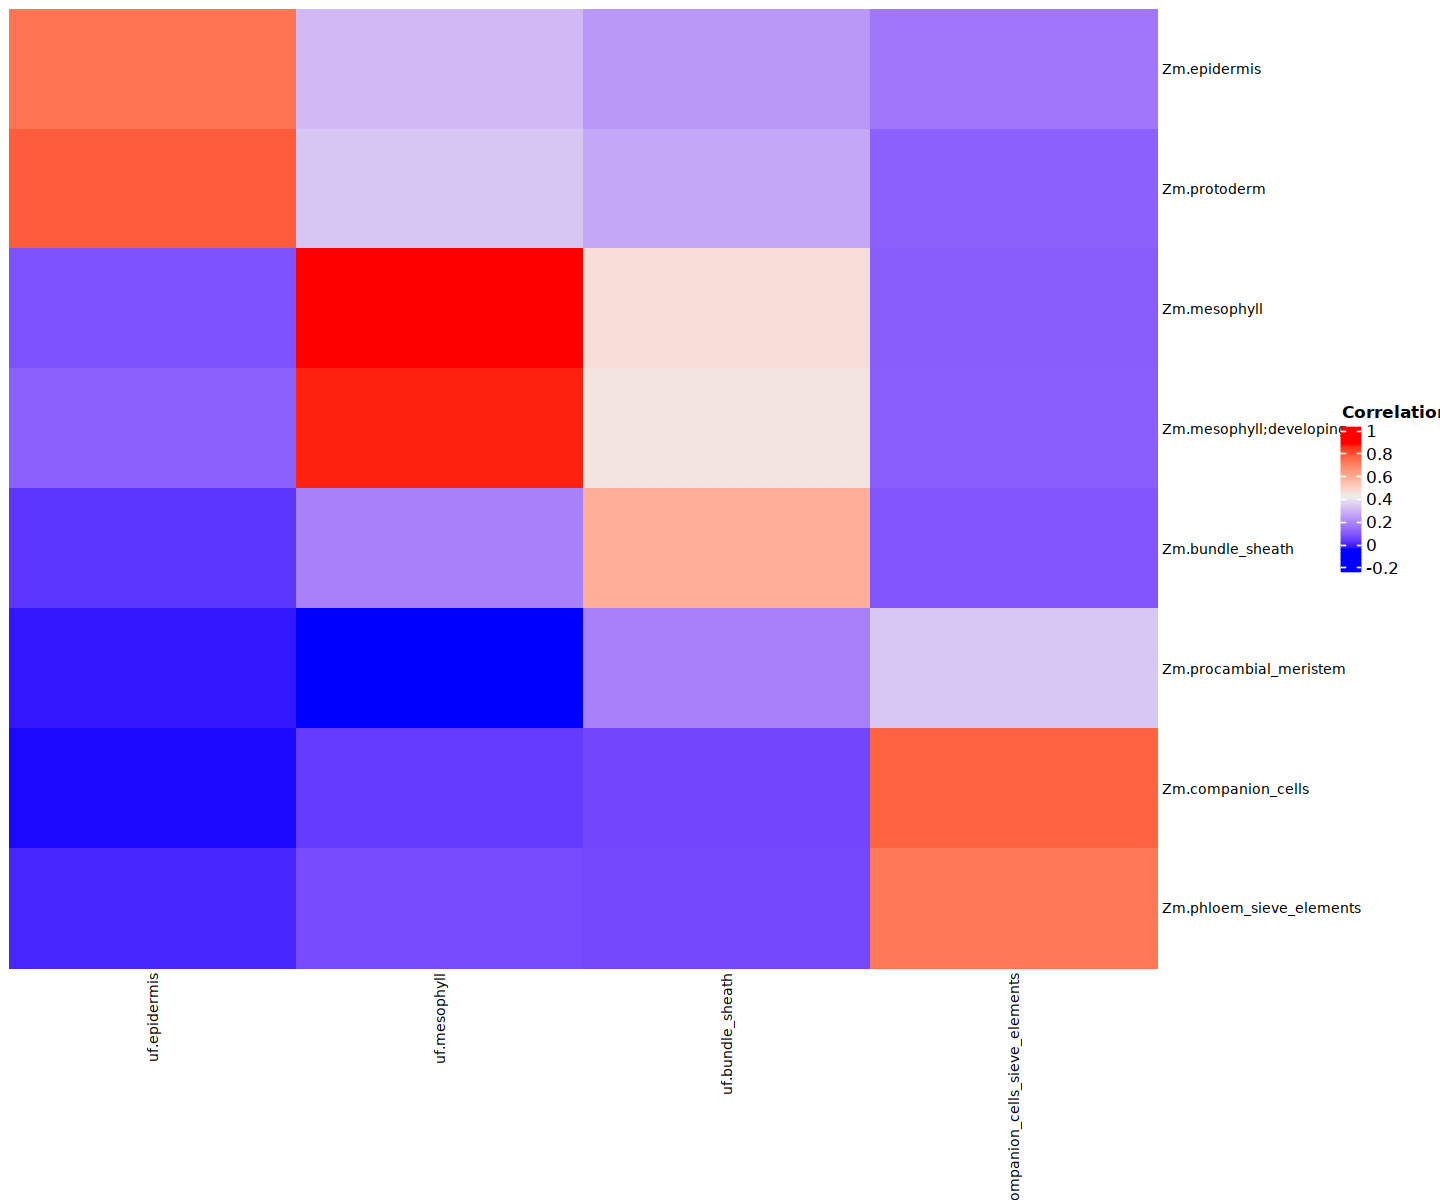

In [19]:
## Generating Orderer on Marker Genes 
uf_order <- c('uf.epidermis',
    'uf.mesophyll',
    'uf.bundle_sheath',
    'uf.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)

zm.cell_types.dropped <- zm.cell_types
uf.cell_types.dropped <- uf.cell_types 

options(repr.plot.width=12, repr.plot.height=10)
marker_corr_matrix <- cor((zm.cell_types.dropped), (uf.cell_types.dropped))


zm_uf_markers_ordered <- Heatmap(marker_corr_matrix,
        row_order = zm_order,
        column_order = uf_order,
        column_names_gp = grid::gpar(fontsize = 8),
        row_names_gp = grid::gpar(fontsize = 8),
        heatmap_legend_param = list(
            title = "Correlation",
            legend_width = unit(6, "cm")))
zm_uf_markers_ordered

In [20]:
## Working now on Single Copy Ortholouges

uf_vs_Zm_orthos <- read_delim("/home/jpm73279/genome_downloads/Ufusca/Ufusca.prot__v__Zm-B73.prot.tsv") 

#Gross output here that needs to be fixed from orthofinder.
colnames(uf_vs_Zm_orthos) <- sub("-", "_", colnames(uf_vs_Zm_orthos), fixed = TRUE)

Rows: 18734 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Orthogroup, Ufusca.prot, Zm-B73.prot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
head(uf_vs_Zm_orthos)

Orthogroup,Ufusca.prot,Zm_B73.prot
<chr>,<chr>,<chr>
OG0000001,"Urofu.7G148700.1.p, Urofu.4G044300.1.p, Urofu.4G134800.1.p, Urofu.4G294900.1.p, Urofu.6G110100.1.p, Urofu.9G452300.1.p, Urofu.9G266300.1.p, Urofu.5G335500.1.p, Urofu.1G298800.1.p, Urofu.4G069300.1.p, Urofu.3G340400.1.p, Urofu.4G134000.1.p, Urofu.8G116600.1.p, Urofu.8G074800.1.p, Urofu.7G133500.1.p, Urofu.1G238200.1.p, Urofu.2G055700.1.p, Urofu.2G079300.1.p, Urofu.6G147500.1.p, Urofu.9G215300.1.p, Urofu.7G030800.1.p, Urofu.5G462600.1.p, Urofu.5G323900.1.p, Urofu.3G094300.1.p, Urofu.2G291400.1.p, Urofu.3G336900.1.p, Urofu.6G032600.1.p, Urofu.9G284000.1.p, Urofu.9G085500.1.p, Urofu.2G001600.1.p",Zm00001eb279530_P001
OG0000003,"Urofu.3G006100.1.p, Urofu.9G497900.1.p, Urofu.5G059300.1.p, Urofu.9G203800.1.p, Urofu.8G002600.1.p",Zm00001eb276920_P002
OG0000004,"Urofu.7G020000.1.p, Urofu.7G016300.1.p",Zm00001eb050830_P001
OG0000004,"Urofu.3G167400.1.p, Urofu.9G416000.1.p, Urofu.9G415900.1.p, Urofu.9G415800.1.p, Urofu.9G110200.1.p, Urofu.7G029700.1.p, Urofu.9G470100.1.p, Urofu.8G054900.1.p, Urofu.9G152200.1.p, Urofu.9G152100.1.p, Urofu.9G152700.1.p, Urofu.9G152800.1.p, Urofu.9G183500.1.p, Urofu.3G304300.1.p, Urofu.9G175800.1.p",Zm00001eb116750_P003
OG0000006,"Urofu.2G305200.1.p, Urofu.2G304900.1.p",Zm00001eb104100_P001
OG0000006,Urofu.2G304300.1.p,Zm00001eb321100_P001


In [22]:
uf_vs_Zm_orthos.fixed <- uf_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(uf_count = str_count(Ufusca.prot, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(uf_count == 0 & Zm_count == 0) %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    mutate(uf_gene = str_replace(Ufusca.prot, ".1.p", ".v1.1"))
    


In [23]:
head(uf_vs_Zm_orthos.fixed)

Orthogroup,Ufusca.prot,Zm_B73.prot,uf_count,Zm_count,zm_gene,uf_gene
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
OG0000006,Urofu.2G304300.1.p,Zm00001eb321100_P001,0,0,Zm00001eb321100,Urofu.2G304300.v1.1
OG0000006,Urofu.2G304200.1.p,Zm00001eb104090_P001,0,0,Zm00001eb104090,Urofu.2G304200.v1.1
OG0000006,Urofu.2G304000.1.p,Zm00001eb321140_P001,0,0,Zm00001eb321140,Urofu.2G304000.v1.1
OG0000007,Urofu.2G107300.1.p,Zm00001eb305320_P001,0,0,Zm00001eb305320,Urofu.2G107300.v1.1
OG0000007,Urofu.8G210000.1.p,Zm00001eb416480_P001,0,0,Zm00001eb416480,Urofu.8G210000.v1.1
OG0000007,Urofu.9G072400.1.p,Zm00001eb058940_P001,0,0,Zm00001eb058940,Urofu.9G072400.v1.1


In [24]:
uf.zm.single_copy <- uf_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, zm_gene, uf_gene)

In [25]:
uf.cell_types.all_orthos <- left_join(uf.zm.single_copy, uf.cell_type_accessability, by = c("uf_gene" = "geneID")) %>% 
    drop_na()


zm.cell_types.all_orthos <- left_join(uf.zm.single_copy, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(uf_gene %in% uf.cell_types.all_orthos$uf_gene)


In [26]:
str(uf.cell_types.all_orthos)

tibble [12,481 × 7] (S3: tbl_df/tbl/data.frame)
 $ Orthogroup                       : chr [1:12481] "OG0000006" "OG0000006" "OG0000006" "OG0000007" ...
 $ zm_gene                          : chr [1:12481] "Zm00001eb321100" "Zm00001eb104090" "Zm00001eb321140" "Zm00001eb305320" ...
 $ uf_gene                          : chr [1:12481] "Urofu.2G304300.v1.1" "Urofu.2G304200.v1.1" "Urofu.2G304000.v1.1" "Urofu.2G107300.v1.1" ...
 $ uf.bundle_sheath                 : num [1:12481] 36.946 1.013 2.05 1.288 0.613 ...
 $ uf.companion_cells_sieve_elements: num [1:12481] 47.733 0.712 16.861 0.712 2.375 ...
 $ uf.epidermis                     : num [1:12481] 45.57 24.122 15.019 8.022 0.939 ...
 $ uf.mesophyll                     : num [1:12481] 81.62 3.21 11.898 3.381 0.514 ...


In [27]:
dim(uf.cell_types.all_orthos)

[1] 12481     7

In [28]:
uf.cell_types.all_orthos.final <- uf.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.all_orthos.final <- zm.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

In [29]:
dim(zm.cell_types.all_orthos.final)
dim(uf.cell_types.all_orthos.final)

[1] 12481     8

[1] 12481     4

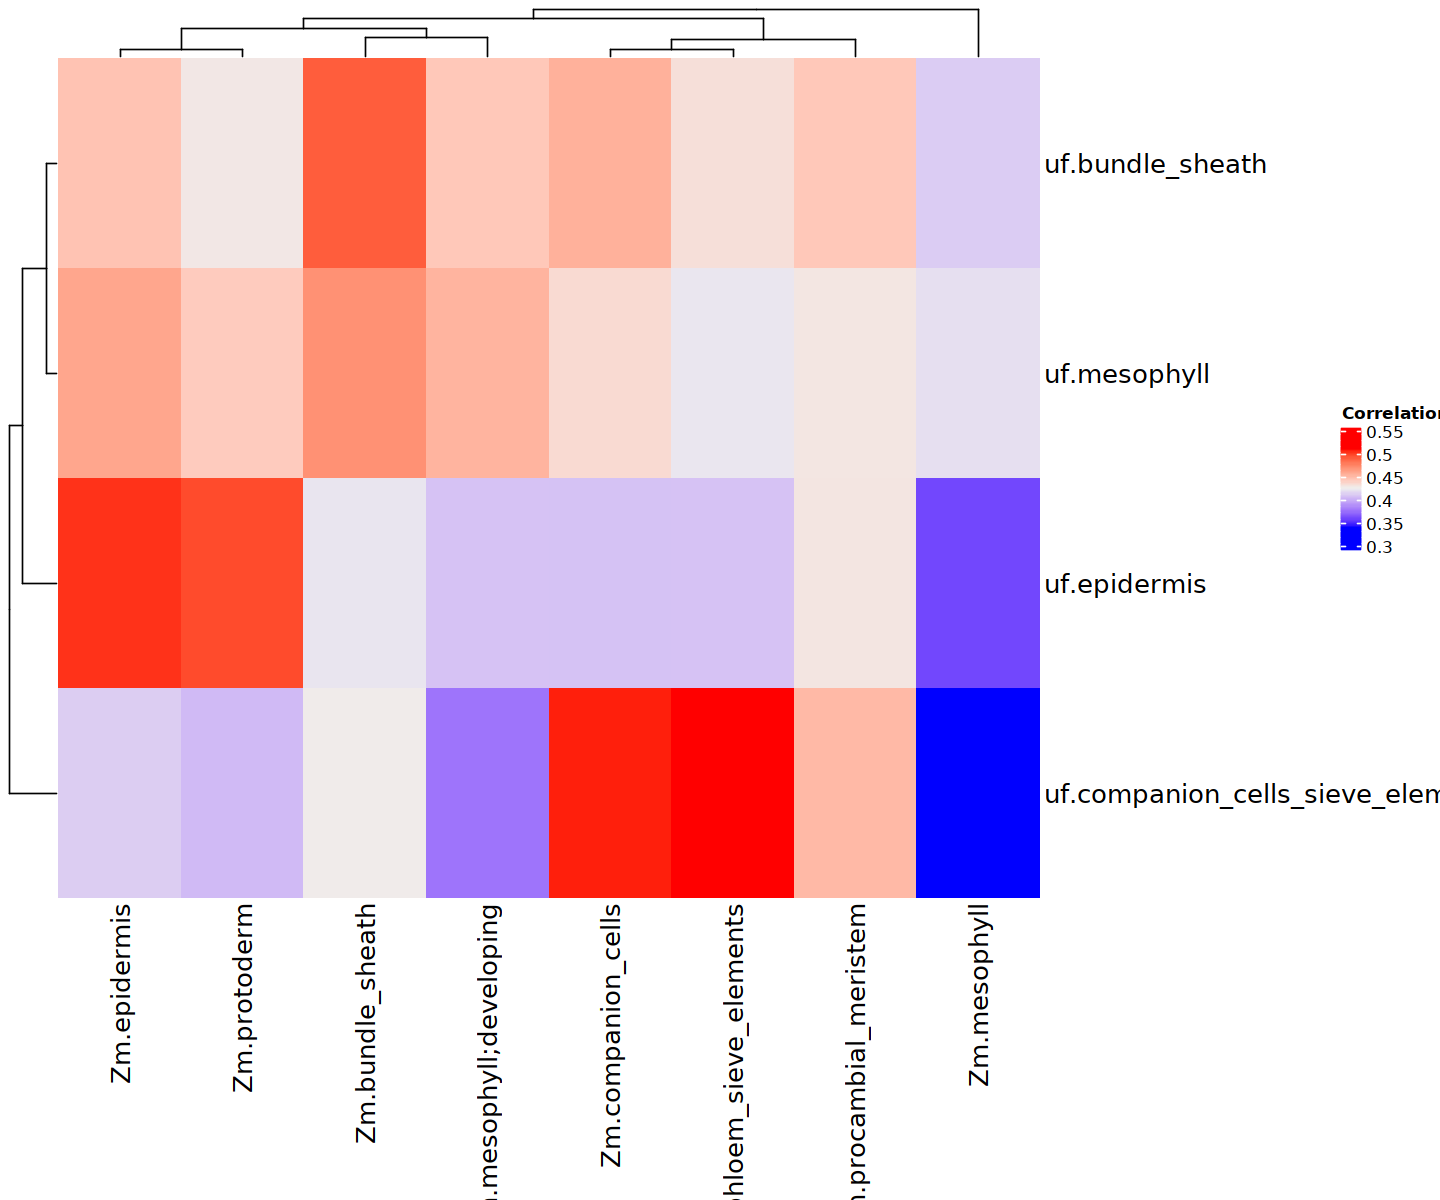

In [30]:
options(repr.plot.width=12, repr.plot.height=10)
all_orthos_corr <- cor((uf.cell_types.all_orthos.final), (zm.cell_types.all_orthos.final))
Heatmap(all_orthos_corr,
                                      column_names_gp = grid::gpar(fontsize = 15),
                                      row_names_gp = grid::gpar(fontsize = 15),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

# Selecting the 1000-2000 most variable single copy orthos

In [31]:
head(uf.cell_types.all_orthos)
head(zm.cell_types.all_orthos)

Orthogroup,zm_gene,uf_gene,uf.bundle_sheath,uf.companion_cells_sieve_elements,uf.epidermis,uf.mesophyll
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000006,Zm00001eb321100,Urofu.2G304300.v1.1,36.9456502,47.732810,45.5702852,81.6197117
OG0000006,Zm00001eb104090,Urofu.2G304200.v1.1,1.0127234,0.712430,24.1220986,3.2100044
OG0000006,Zm00001eb321140,Urofu.2G304000.v1.1,2.0504523,16.860843,15.0194199,11.8984163
OG0000007,Zm00001eb305320,Urofu.2G107300.v1.1,1.2877841,0.712430,8.0217356,3.3812046
OG0000007,Zm00001eb416480,Urofu.8G210000.v1.1,0.6126351,2.374767,0.9387137,0.5136007
OG0000007,Zm00001eb058940,Urofu.9G072400.v1.1,199.6315387,79.079730,190.2744307,225.9843093


Orthogroup,zm_gene,uf_gene,Zm.bundle_sheath,Zm.companion_cells,Zm.epidermis,Zm.mesophyll,Zm.mesophyll;developing,Zm.phloem_sieve_elements,Zm.procambial_meristem,Zm.protoderm
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000006,Zm00001eb321100,Urofu.2G304300.v1.1,50.6301464,29.054591,35.698029,97.516806,121.652960,53.829366,22.138955,71.270541
OG0000006,Zm00001eb104090,Urofu.2G304200.v1.1,18.0821951,3.631824,39.968128,13.193450,27.878803,27.370864,29.518607,29.316960
OG0000006,Zm00001eb321140,Urofu.2G304000.v1.1,0.7232878,1.815912,18.105220,3.728584,5.068873,2.737086,3.689826,4.043719
OG0000007,Zm00001eb305320,Urofu.2G107300.v1.1,10.1260293,14.527295,76.690981,13.910486,12.672183,8.211259,18.449129,55.601132
OG0000007,Zm00001eb416480,Urofu.8G210000.v1.1,4.8821927,3.631824,8.369394,4.015398,2.534437,6.386535,3.689826,5.054648
OG0000007,Zm00001eb058940,Urofu.9G072400.v1.1,143.7534514,106.230848,155.602413,186.142374,169.807256,145.065581,84.865995,131.673589


In [32]:
head(uf.cell_types.all_orthos)

Orthogroup,zm_gene,uf_gene,uf.bundle_sheath,uf.companion_cells_sieve_elements,uf.epidermis,uf.mesophyll
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000006,Zm00001eb321100,Urofu.2G304300.v1.1,36.9456502,47.732810,45.5702852,81.6197117
OG0000006,Zm00001eb104090,Urofu.2G304200.v1.1,1.0127234,0.712430,24.1220986,3.2100044
OG0000006,Zm00001eb321140,Urofu.2G304000.v1.1,2.0504523,16.860843,15.0194199,11.8984163
OG0000007,Zm00001eb305320,Urofu.2G107300.v1.1,1.2877841,0.712430,8.0217356,3.3812046
OG0000007,Zm00001eb416480,Urofu.8G210000.v1.1,0.6126351,2.374767,0.9387137,0.5136007
OG0000007,Zm00001eb058940,Urofu.9G072400.v1.1,199.6315387,79.079730,190.2744307,225.9843093


In [33]:
combined_uf_zm <- full_join(uf.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_uf_zm.subset <- combined_uf_zm  %>% 
    #dplyr::select(-zm_gene, -uf_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, uf_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)

Joining with `by = join_by(Orthogroup, zm_gene, uf_gene)`


In [34]:
combined_uf_zm.subset.mean.var <- combined_uf_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_uf_zm.subset.mean.var)

combined_uf_zm.subset.mean.var.final <- combined_uf_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(2000)

Selecting by resid


In [35]:
combined_uf_zm.subset.mean.var.final.split <- combined_uf_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "uf_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, uf_gene)

In [36]:
uf.cell_types.var_orthos.final <- left_join(combined_uf_zm.subset.mean.var.final.split, uf.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_uf_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

Joining with `by = join_by(Orthogroup, zm_gene, uf_gene)`
Joining with `by = join_by(Orthogroup, zm_gene, uf_gene)`


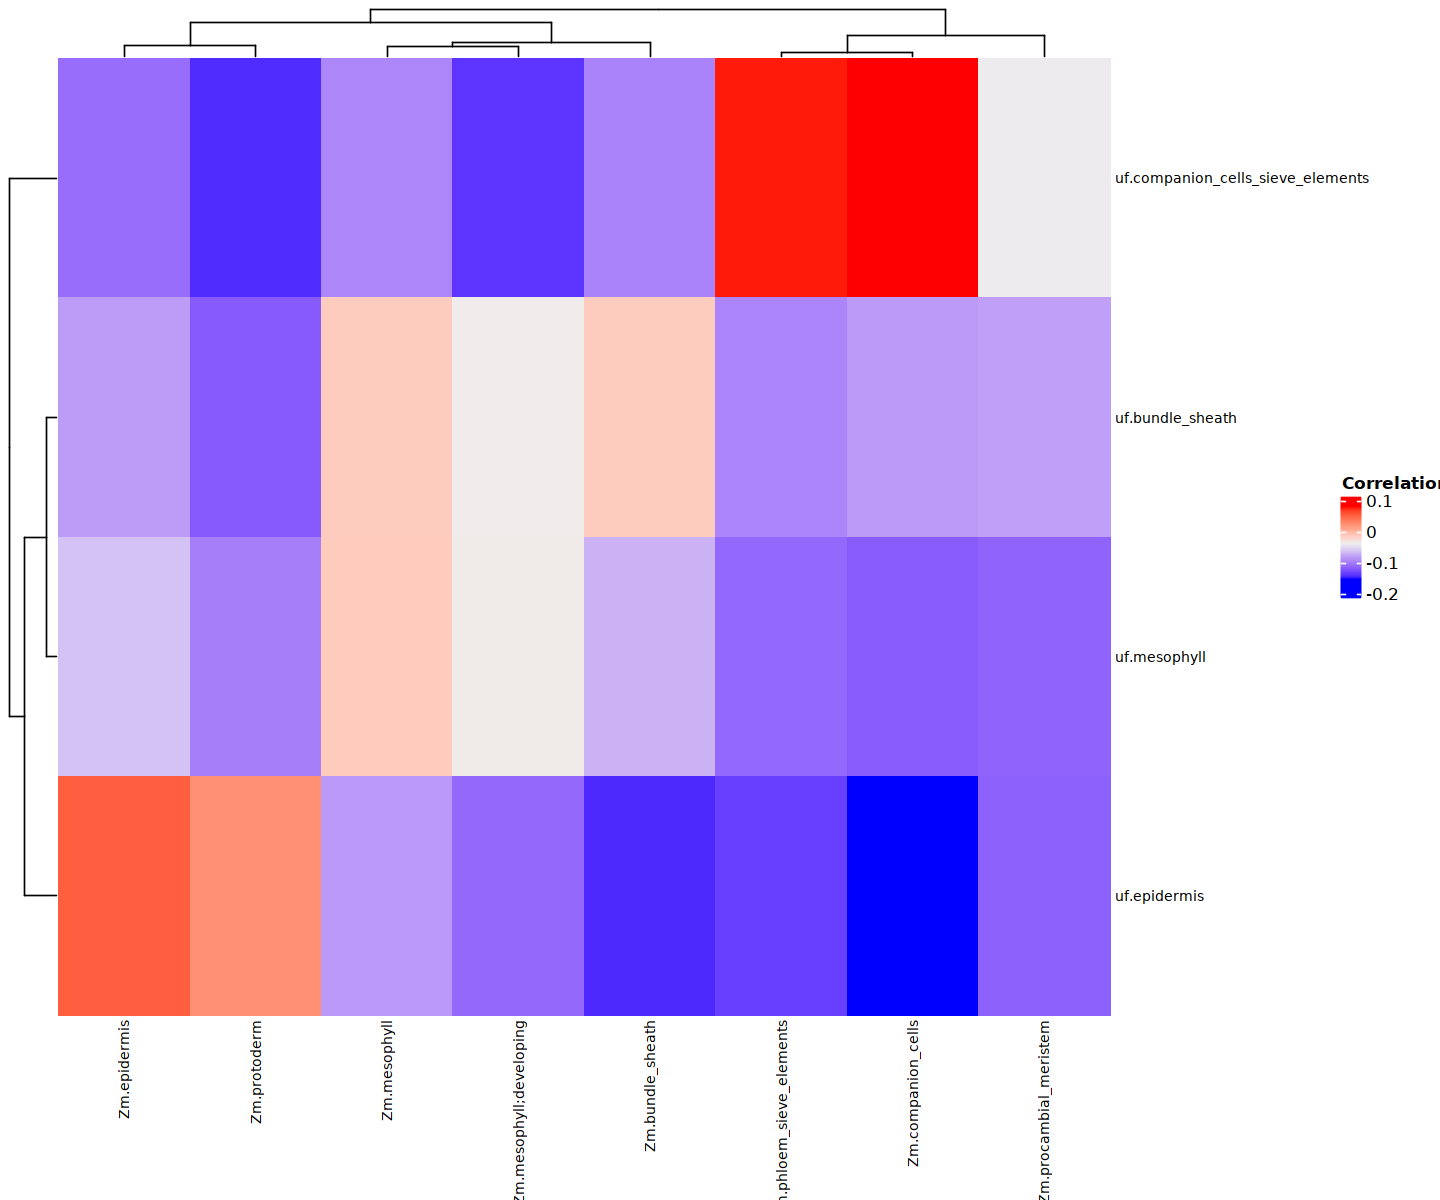

In [37]:
options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((uf.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

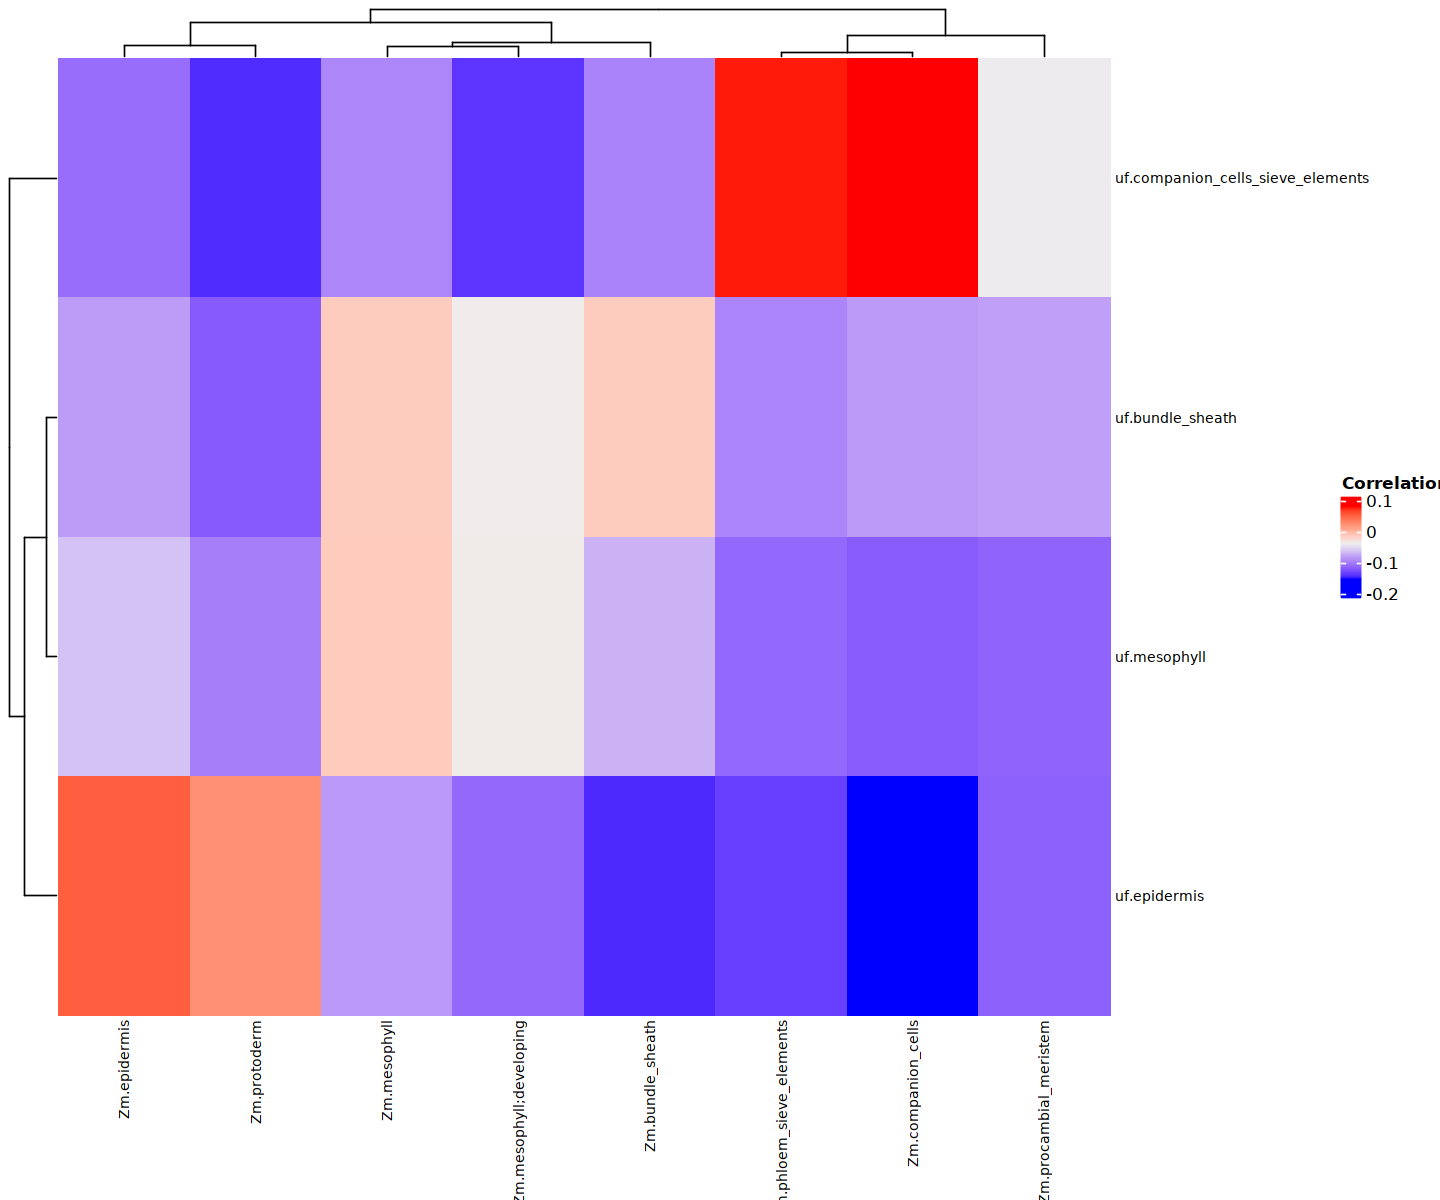

In [38]:
uf.cell_types.var_orthos.final.sub_select <- uf.cell_types.var_orthos.final

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final

options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((uf.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
zm_vs_uf_2000_orthos <-  Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_uf_2000_orthos


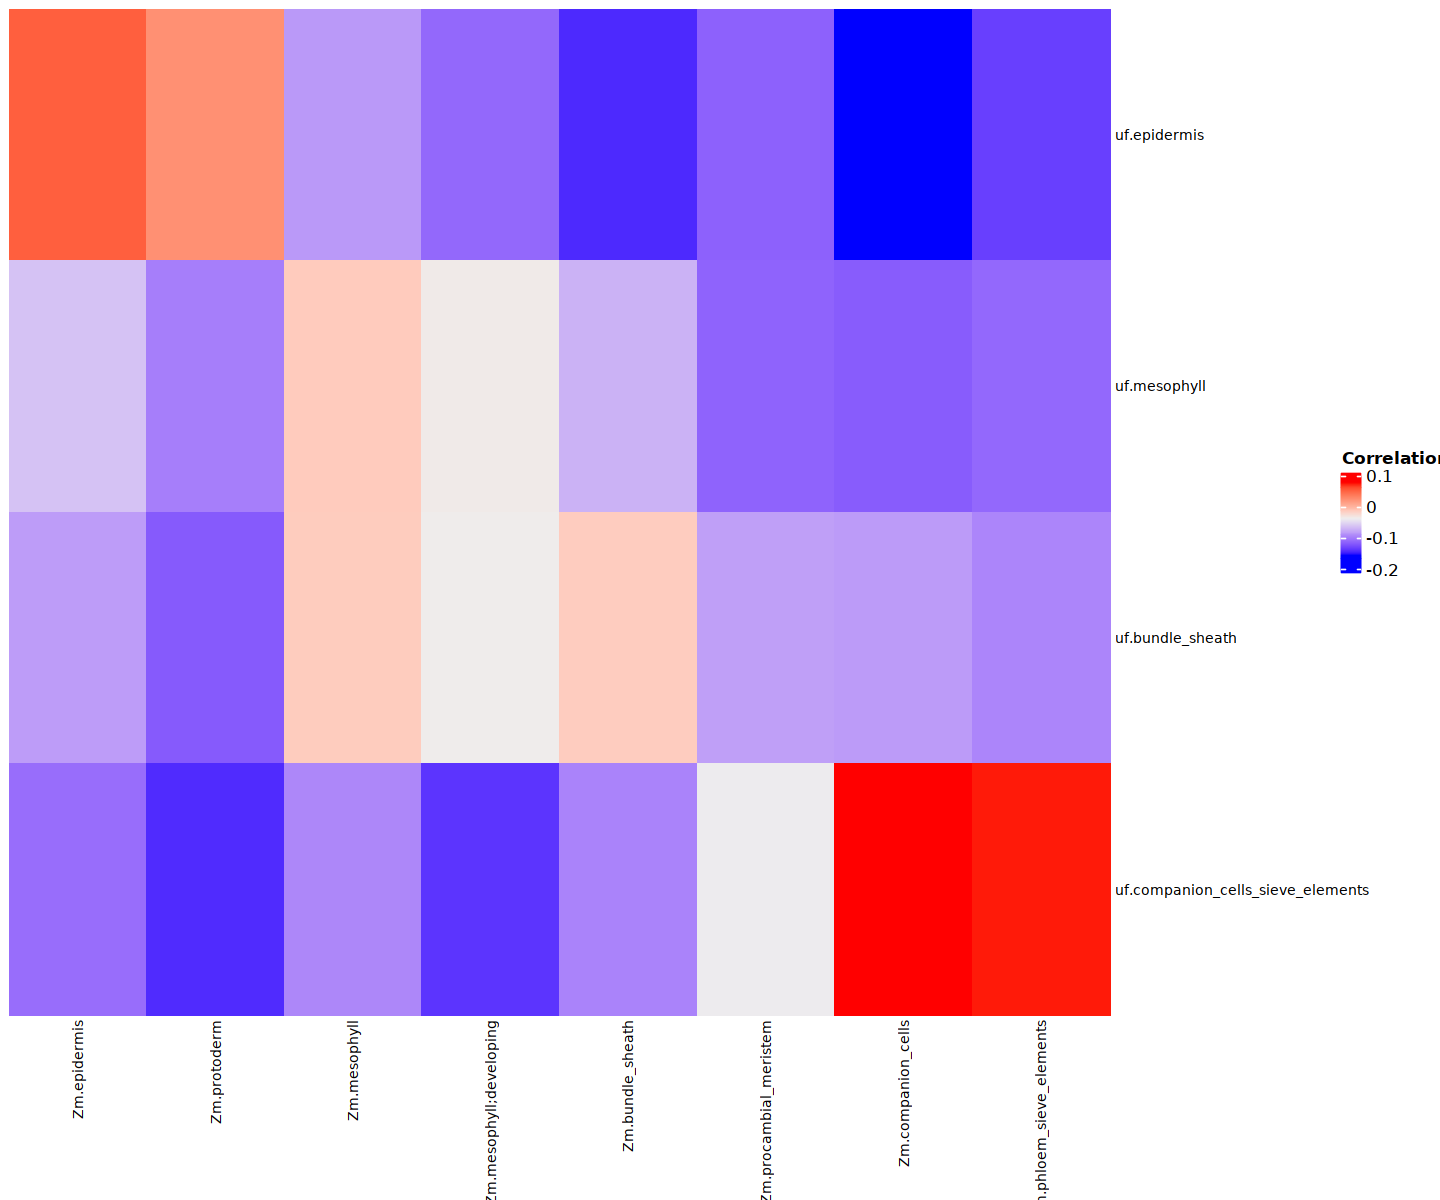

In [39]:
uf.cell_types.var_orthos.final.sub_select <- uf.cell_types.var_orthos.final 

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final


uf_order <- c('uf.epidermis',
    'uf.mesophyll',
    'uf.bundle_sheath',
    'uf.companion_cells_sieve_elements')


zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((uf.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
zm_vs_uf_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = uf_order,
        column_order = zm_order,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_uf_2000_orthos_ordered

In [ ]:
var.orthos.final <- cor((uf.cell_types.var_orthos.final.sub_select), (uf.cell_types.var_orthos.final.sub_select))
uf_vs_uf_2000_orthos<-  Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

uf_vs_uf_2000_orthos

In [ ]:
var.orthos.final <- cor((zm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm_vs_zm_2000_orthos <- Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_zm_2000_orthos 


In [ ]:
## Note that useful - Skipping this 
combined_uf_zm.subset.mean.var.final.split <- combined_uf_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "uf_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, uf_gene)

uf.cell_types.var_orthos.final <- left_join(combined_uf_zm.subset.mean.var.final.split, uf.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_uf_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

all_vs_all <- bind_cols(zm.cell_types.var_orthos.final, uf.cell_types.var_orthos.final)

# Convert all elements to numeric
all_vs_all <- apply(all_vs_all, 2, function(x) as.numeric(as.character(x)))
# Convert back to matrix
all_vs_all <- as.matrix(all_vs_all)
all_vs_all[is.na(all_vs_all)] = 0

cell_type_corr_matrix <- cor(all_vs_all)





options(repr.plot.width=12, repr.plot.height=10)
Heatmap(cell_type_corr_matrix)

In [ ]:
# Selecting Zm and uf Orthos more efficiently 

uf_vs_Zm_orthos.fixed <- uf_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(uf_count = str_count(ufiliaceum.prot, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(uf_count <= 4 & Zm_count == 0) #%>% 
    #mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    #mutate(uf_gene = ufiliaceum.prot)
    




In [ ]:
head(uf_merged_meta_cuf_information_copied)

In [ ]:
uf_genes_most_highly_acc <- uf_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, ufiliaceum.prot)  %>% 
    rowwise()  %>% 
    separate_rows(ufiliaceum.prot, sep = ",\\s*")  %>% 
    mutate(uf_gene = ufiliaceum.prot)  %>% 
    left_join(.,uf_merged_meta_cuf_information_copied, by = c("uf_gene" = "geneID"))  %>% 
    dplyr::filter(is.na(quant_norm_cuf) != TRUE)  %>% 
      group_by(Orthogroup) %>%
      slice_sample(weight_by = grouped_Cuf, n = 1) %>%
      ungroup()  %>% 
    dplyr::select(Orthogroup, ufiliaceum.prot)


In [ ]:
head(uf_vs_Zm_orthos.fixed)

In [ ]:
uf_vs_Zm_orthos.fixed.highly_acc_uf <- uf_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, Zm_B73.prot)  %>% 
    left_join(., uf_gemes_most_highly_acc, by = c("Orthogroup"))  %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", ""))  %>% 
    mutate(uf_gene = ufiliaceum.prot)  %>% 
    dplyr::select(-ufiliaceum.prot, -Zm_B73.prot)


In [ ]:
uf.cell_types.all_orthos <- left_join(uf_vs_Zm_orthos.fixed.highly_acc_uf, uf.cell_type_accessability, by = c("uf_gene" = "geneID")) %>% 
    drop_na()

zm.cell_types.all_orthos <- left_join(uf_vs_Zm_orthos.fixed.highly_acc_uf, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(uf_gene %in% uf.cell_types.all_orthos$uf_gene)   



In [ ]:
str(uf.cell_types.all_orthos)

In [ ]:
combined_uf_zm <- full_join(uf.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_uf_zm.subset <- combined_uf_zm  %>% 
    #dplyr::select(-zm_gene, -uf_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, uf_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)

combined_uf_zm.subset.mean.var <- combined_uf_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

In [ ]:
head(combined_uf_zm.subset.mean.var)

In [ ]:
regression <- loess(logscore ~ species, data=combined_uf_zm.subset.mean.var)

combined_uf_zm.subset.mean.var.final <- combined_uf_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(1000)

combined_uf_zm.subset.mean.var.final.split <- combined_uf_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "uf_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, uf_gene)

uf.cell_types.var_orthos.final <- left_join(combined_uf_zm.subset.mean.var.final.split, uf.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_uf_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)


uf.cell_types.acc_quant <- uf.cell_types.all_orthos  %>%
    dplyr::filter(Orthogroup %in% combined_uf_zm.subset.mean.var.final.split$Orthogroup)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.acc_quant <- zm.cell_types.all_orthos  %>% 
    dplyr::filter(Orthogroup %in% combined_uf_zm.subset.mean.var.final.split$Orthogroup)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -uf_gene)  %>% 
    replace(is.na(.), 0)



uf_order <- c('uf.epidermis',
    'uf.protoderm',
    'uf.mesophyll',
    'uf.mesophyll;developing',
    'uf.bundle_sheath',
    'uf.procambium',
    'uf.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((uf.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm_vs_uf_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = uf_order,
        column_order = zm_order,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_uf_2000_orthos_ordered

In [40]:
## Fix Regression: 
acc_by_cell_type_species <- combined_uf_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    mutate(species = case_when(
    str_starts(cell_type, "uf") ~ "uf",
    str_starts(cell_type, "Zm") ~ "Zm"))  %>% 
    ungroup()  %>% 
  mutate(species_id = row_number()) %>%
  pivot_wider(names_from = species, values_from = species_id,
              values_fill = 0, values_fn = length)  %>% 
    mutate(logscore = log1p(score))


##mean_ortho_var_by_species  <- acc_by_cell_type_species %>% 
 #   group_by(ortho_unique,species)  %>% 
 #   summarize(mean = mean(score),
 #           var = var(score))  %>% 
 # mutate(species_id = row_number()) %>%
 # pivot_wider(names_from = species, values_from = species_id,
 #             values_fill = 0, values_fn = length)  %>% 
 #   ungroup()

In [41]:
head(acc_by_cell_type_species)

ortho_unique,cell_type,score,uf,Zm,logscore
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
OG0000006__Zm00001eb321100__Urofu.2G304300.v1.1,uf.bundle_sheath,36.94565,1,0,3.636155
OG0000006__Zm00001eb321100__Urofu.2G304300.v1.1,uf.companion_cells_sieve_elements,47.73281,1,0,3.886353
OG0000006__Zm00001eb321100__Urofu.2G304300.v1.1,uf.epidermis,45.57029,1,0,3.840963
OG0000006__Zm00001eb321100__Urofu.2G304300.v1.1,uf.mesophyll,81.61971,1,0,4.414248
OG0000006__Zm00001eb321100__Urofu.2G304300.v1.1,Zm.bundle_sheath,50.63015,0,1,3.944106
OG0000006__Zm00001eb321100__Urofu.2G304300.v1.1,Zm.companion_cells,29.05459,0,1,3.403015


In [114]:
#head(acc_by_species_mean_ave)
regression <- loess(score ~ Zm , data=acc_by_cell_type_species)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.1124e-19”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”


In [115]:
combined_uf_zm.subset.mean.var.final <- acc_by_cell_type_species %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  

In [116]:
gathered_residuals <- combined_uf_zm.subset.mean.var.final  %>% 
    #separate(ortho_unique, into = c("Orthogroup", "zm_gene", "uf_gene"), sep = "__")  %>% 
    dplyr::select(ortho_unique, cell_type, resid) %>% 
    pivot_wider(names_from = cell_type, values_from = resid)

In [45]:
head(gathered_residuals)

ortho_unique,Zm.mesophyll;developing,Zm.procambial_meristem,Zm.companion_cells,Zm.epidermis,Zm.mesophyll,Zm.bundle_sheath,Zm.protoderm,Zm.phloem_sieve_elements,uf.mesophyll,uf.companion_cells_sieve_elements,uf.epidermis,uf.bundle_sheath
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000007__Zm00001eb305300__Urofu.2G107400.v1.1,-2.946712,-0.4560327,-0.5499528,0.814901,-0.9189952,-0.5704694,0.8192742,-0.2598565,-0.6674363,-2.2346044,-0.1285842,-2.0478439
OG0000008__Zm00001eb265020__Urofu.7G291600.v1.1,-1.143539,-2.9467124,-1.9114263,-1.252767,-0.4702634,-2.0520231,-2.2481153,-1.9083017,0.2085852,0.1282579,0.4636087,0.1170285
OG0000008__Zm00001eb069530__Urofu.7G292000.v1.1,-2.946712,-0.8209061,-1.0829834,-1.003930,-1.9457553,-1.7930239,-1.6861729,-1.6284062,-0.3094311,-2.2346044,1.8897450,-2.1025076
OG0000009__Zm00001eb277770__Urofu.4G114400.v1.1,-1.143539,-2.9467124,-1.0829834,-1.252767,-1.8455371,-1.6849877,-1.1458861,-0.6779489,-1.3961764,-1.3845920,-1.0542739,-1.6143719
OG0000009__Zm00001eb169440__Urofu.8G132100.v1.1,-1.684159,-2.9467124,-1.0829834,-1.541971,-1.1052011,-1.7930239,-0.4518368,-1.4099638,-1.8584402,-1.1532673,-1.9717675,-2.0112829
OG0000017__Zm00001eb298800__Urofu.2G010800.v1.1,-2.946712,-2.9467124,-1.4137617,-1.541971,-2.1825214,-1.6849877,-1.3285688,-1.2307887,-2.1146554,-1.8377396,-1.8162630,-1.8078023


In [53]:
head(resid_var)

ortho_unique,Zm.mesophyll;developing,Zm.procambial_meristem,Zm.companion_cells,Zm.epidermis,Zm.mesophyll,Zm.bundle_sheath,Zm.protoderm,Zm.phloem_sieve_elements,uf.mesophyll,uf.companion_cells_sieve_elements,uf.epidermis,uf.bundle_sheath,variation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0001961__Zm00001eb087570__Urofu.7G040100.v1.1,4.509599,2.193383,2.670795,4.402392,5.138869,2.857044,3.757468,2.861730,-2.307292,-2.234604,-2.365222,-2.424516,100.05746
OG0013506__Zm00001eb141250__Urofu.5G037900.v1.1,-1.684159,-2.946712,-2.300680,-1.950487,-2.493328,-2.211976,-1.686173,-1.908302,2.861745,2.960543,2.723925,2.802366,67.60323
OG0000924__Zm00001eb226420__Urofu.7G071900.v1.1,-2.946712,-2.946712,-2.946712,-2.533007,-1.999901,-2.513330,-2.946712,-2.298373,2.110158,2.249145,1.988948,1.900213,59.99471
OG0009249__Zm00001eb103590__Urofu.9G213900.v1.1,-2.946712,-2.946712,-2.946712,-2.652844,-2.588883,-2.638020,-2.946712,-2.298373,1.782912,2.043791,1.580611,2.108385,57.61504
OG0006585__Zm00001eb084840__Urofu.5G426300.v1.1,-2.946712,-2.946712,-2.946712,-2.652844,-2.325898,-2.946712,-2.721385,-2.946712,1.559409,2.150972,1.766080,1.333748,54.88415
OG0000709__Zm00001eb039160__Urofu.3G267700.v1.1,-2.946712,-2.946712,-1.911426,-2.426006,-2.406113,-2.780502,-2.382423,-2.946712,1.907547,2.166027,1.753721,1.647886,54.22883


In [117]:
data_variation <- gathered_residuals %>%
  gather(key = "variable", value = "value", -ortho_unique) %>%
  group_by(ortho_unique) 

In [118]:
#resid_var <- gathered_residuals  %>% 
#    mutate(variation = rowSums((select(., -ortho_unique) - rowMeans(select(., -ortho_unique)))^2)) %>%
#    arrange(desc(abs(variation)))


resid_var <- gathered_residuals %>%
  gather(key = "variable", value = "value", -ortho_unique) %>%
  group_by(ortho_unique) %>%
  summarize(variation = var(value)) %>%
  ungroup() %>%
  arrange(desc(variation))

'%ni%' <- Negate("%in%")
filter_large_outliers <- resid_var %>%
    top_frac(n = 0.001,wt = variation)

# Select the top 1000 most variable rows
top_1000 <- resid_var %>%
    dplyr::filter(ortho_unique %ni% filter_large_outliers$ortho_unique)  %>% 
    head(4000)

In [119]:
top_1000

ortho_unique,variation
<chr>,<dbl>
OG0012764__Zm00001eb319610__Urofu.2G294000.v1.1,32827.30
OG0004239__Zm00001eb163160__Urofu.3G002000.v1.1,31701.70
OG0000993__Zm00001eb041770__Urofu.6G140800.v1.1,29459.73
OG0001918__Zm00001eb254410__Urofu.1G362400.v1.1,29394.71
OG0010583__Zm00001eb431760__Urofu.7G296600.v1.1,28059.00
OG0015069__Zm00001eb055880__Urofu.9G107600.v1.1,27967.67
OG0012064__Zm00001eb001570__Urofu.9G592400.v1.1,27320.85
OG0005770__Zm00001eb163120__Urofu.3G000900.v1.1,26926.23
OG0008297__Zm00001eb225060__Urofu.2G147400.v1.1,25787.33


In [120]:
zm_residuals <- gathered_residuals  %>% 
    dplyr::select(ortho_unique, starts_with("Zm"))  %>% 
    dplyr::filter(ortho_unique %in% top_1000$ortho_unique)  %>% 
    arrange(ortho_unique) %>% 
    select(-ortho_unique)
uf_residuals <- gathered_residuals  %>% 
    dplyr::select(ortho_unique, uf.mesophyll:uf.bundle_sheath)  %>% 
    dplyr::filter(ortho_unique %in% top_1000$ortho_unique)  %>% 
    arrange(ortho_unique) %>% 
    select(-ortho_unique)



zm_residuals[is.na(zm_residuals)] = 0
uf_residuals[is.na(uf_residuals)] = 0

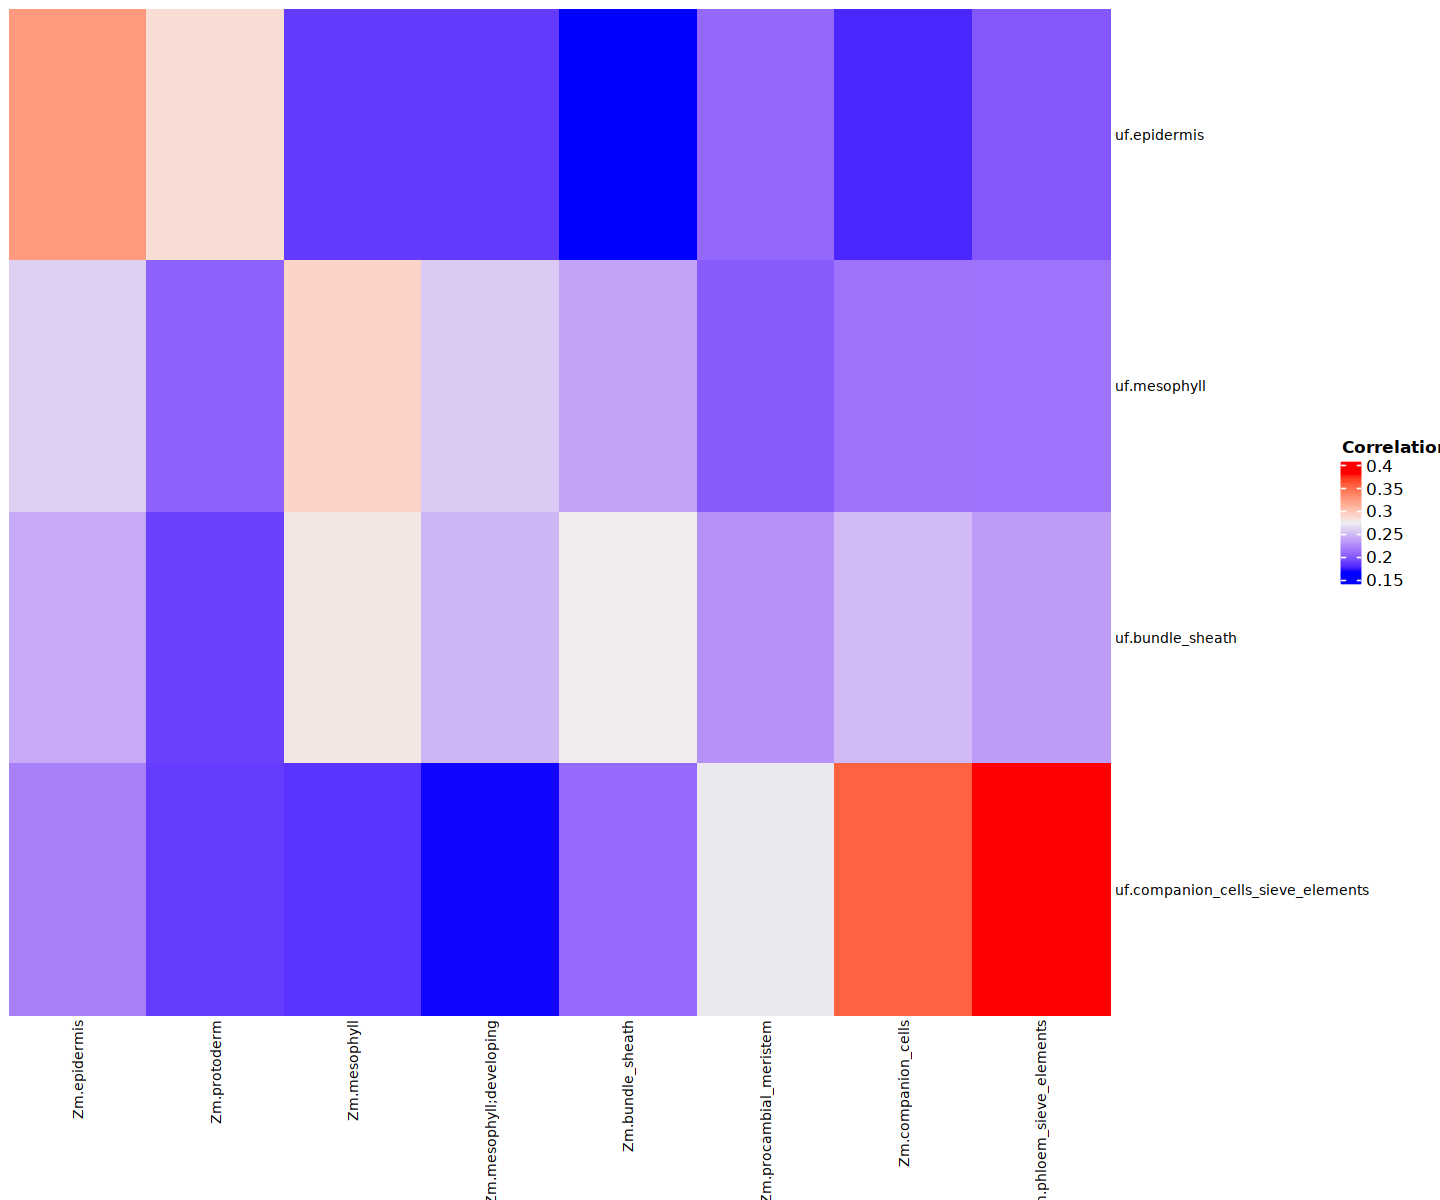

In [121]:
uf_order <- c('uf.epidermis',
    'uf.mesophyll',
    'uf.bundle_sheath',
    'uf.companion_cells_sieve_elements')


zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((uf_residuals), (zm_residuals))
zm_vs_uf_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = uf_order,
        column_order = zm_order,
    column_names_gp = grid::gpar(fontsize = 8),
    row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_uf_2000_orthos_ordered

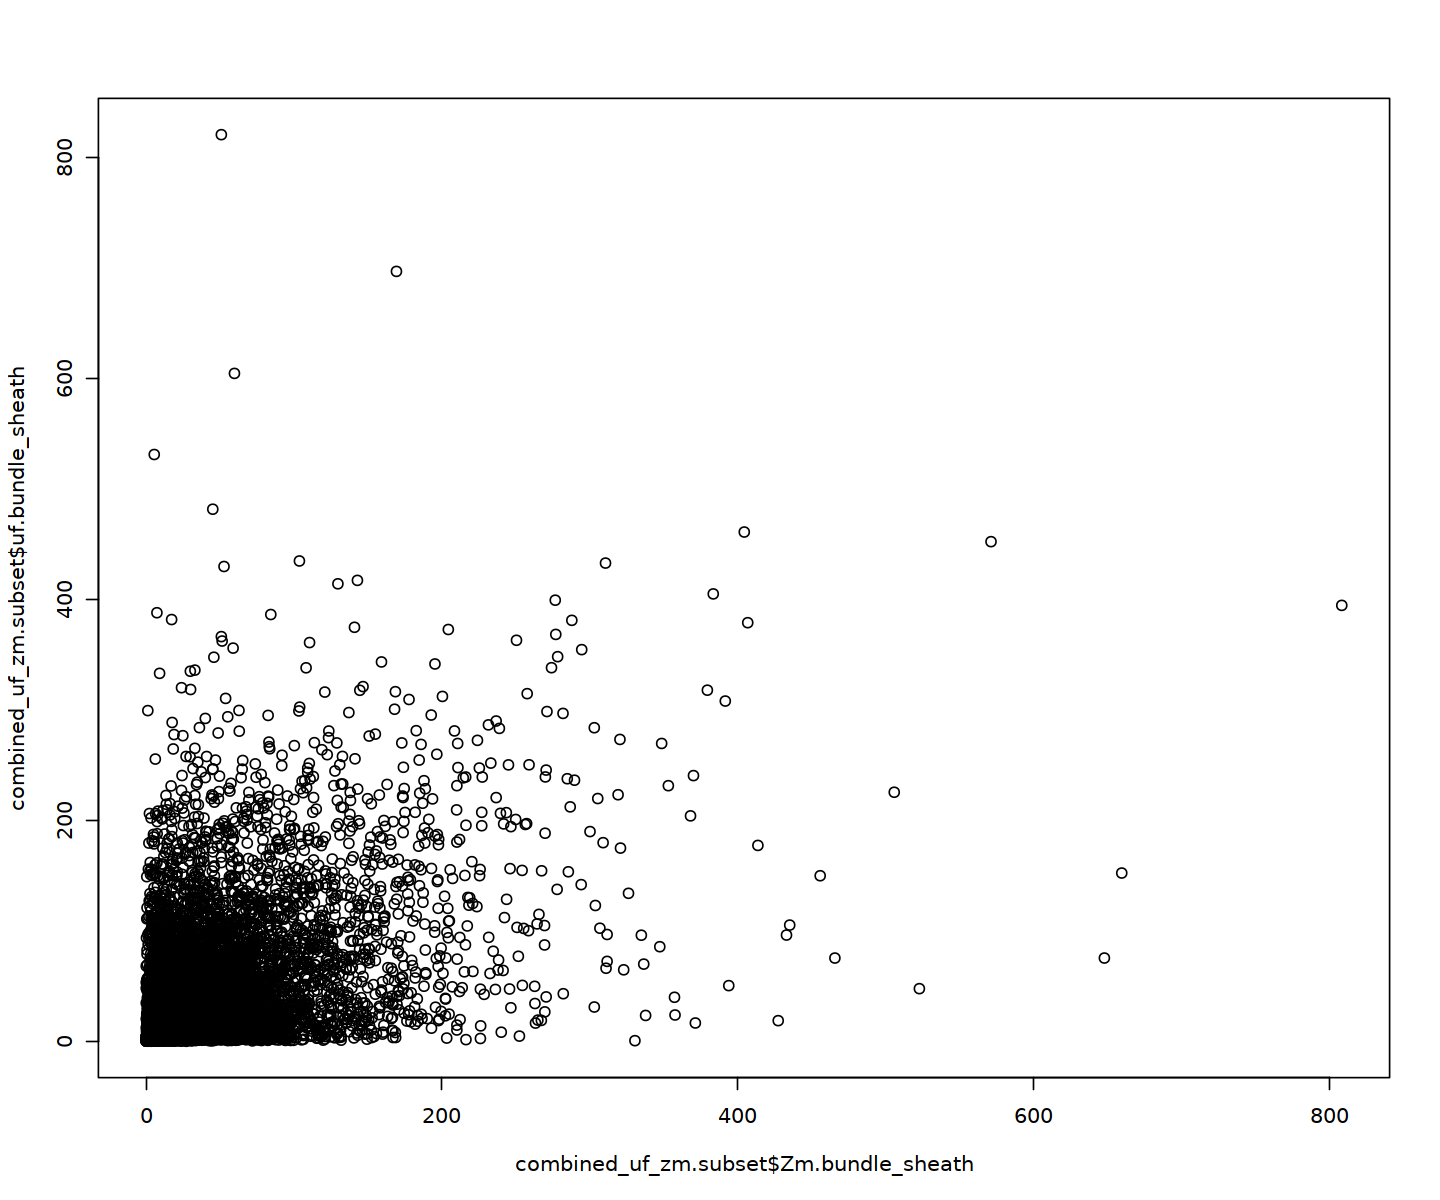

In [122]:
plot(combined_uf_zm.subset$Zm.bundle_sheath, combined_uf_zm.subset$uf.bundle_sheath)

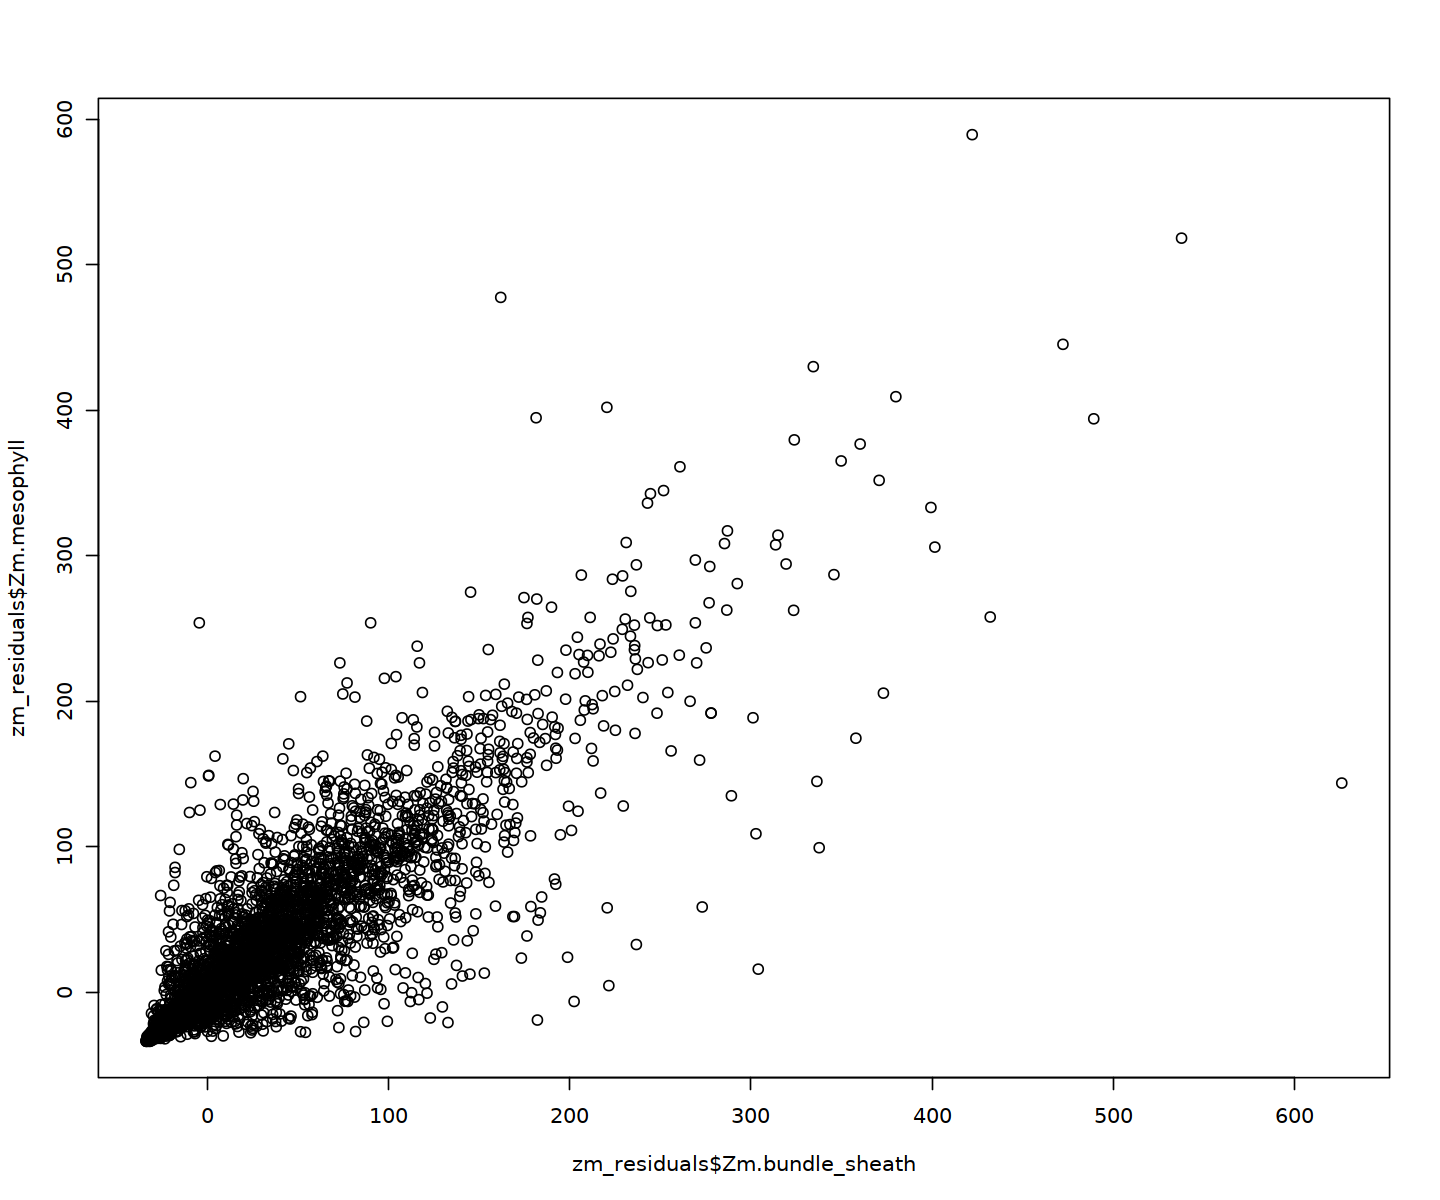

In [123]:
plot(zm_residuals$Zm.bundle_sheath, zm_residuals$Zm.mesophyll)

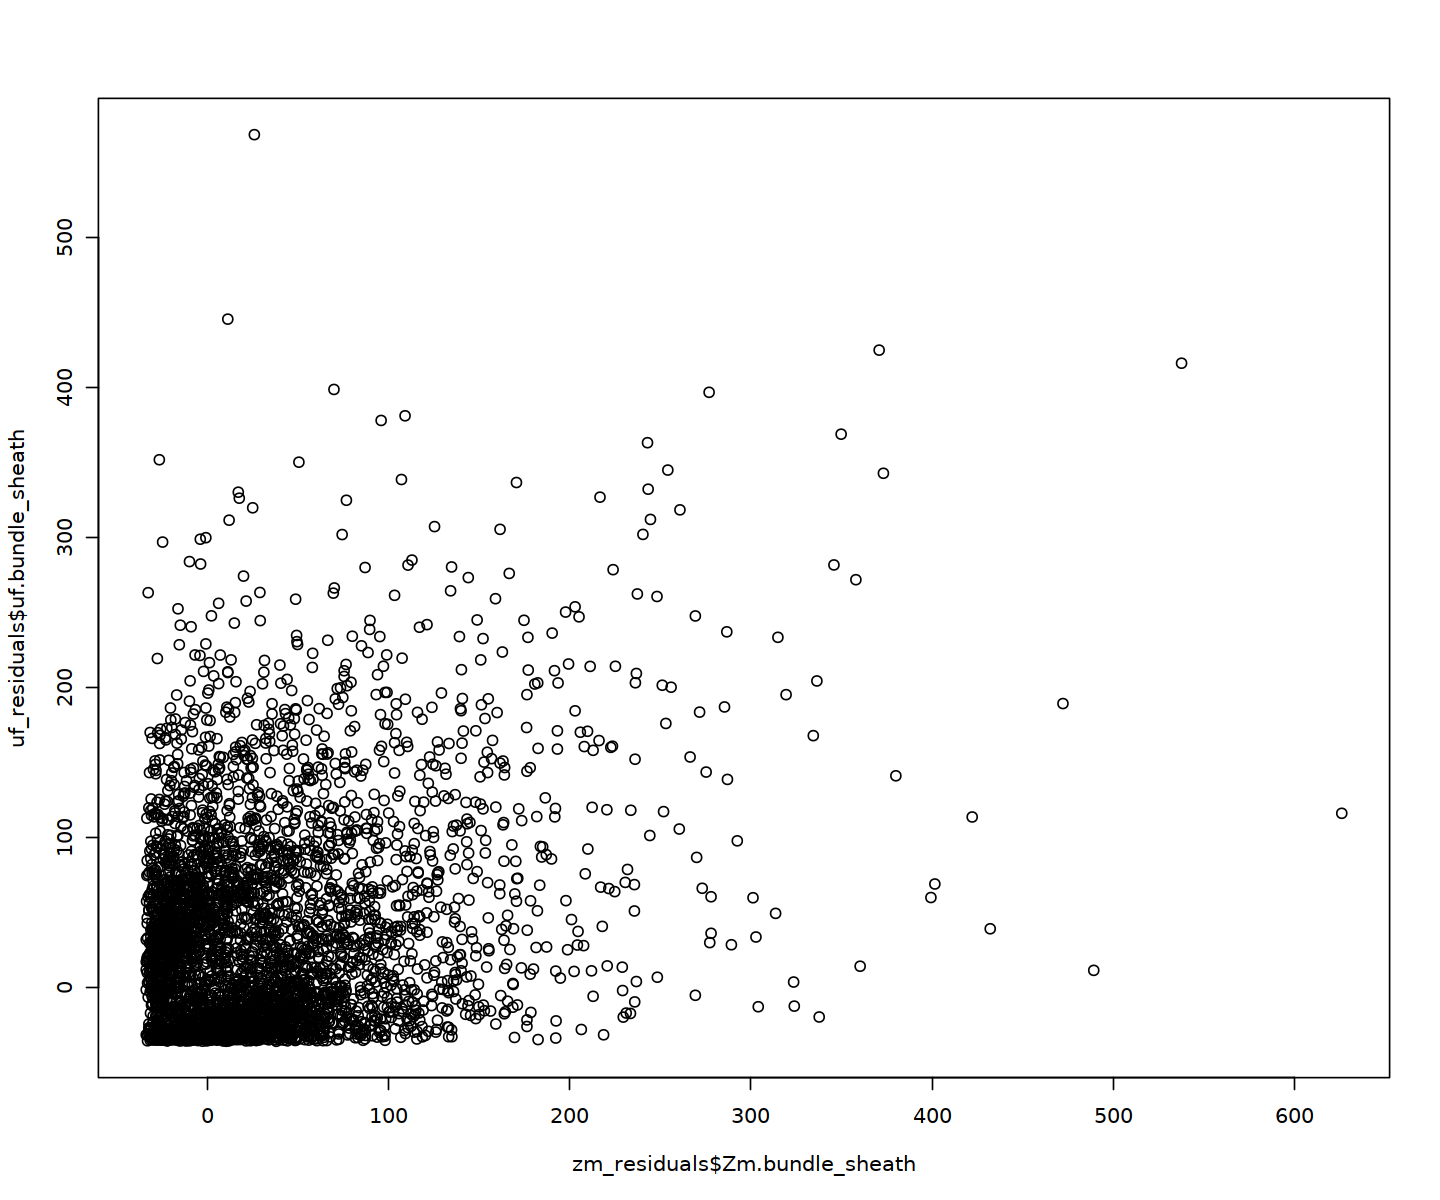

In [126]:
plot(zm_residuals$Zm.bundle_sheath, uf_residuals$uf.bundle_sheath)

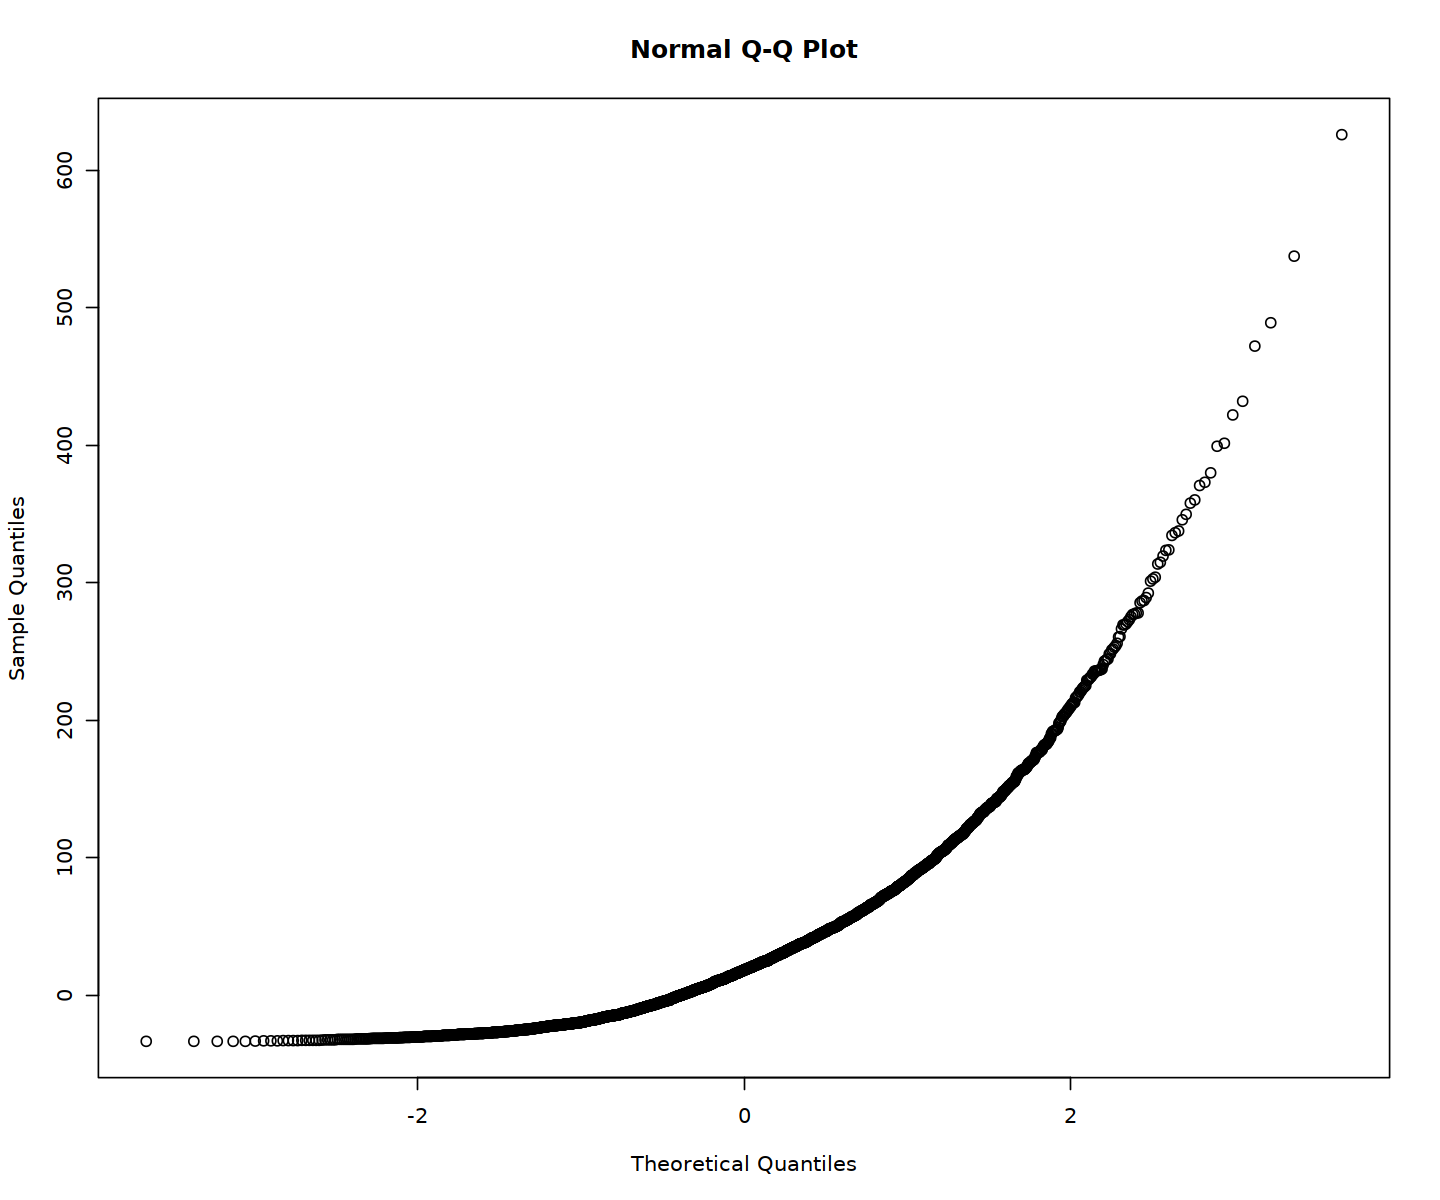

In [125]:
qqnorm(zm_residuals$Zm.bundle_sheath)

In [ ]:
## Saving all heatmaps 

pdf(file="/home/juf73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_uf_marker_corr_3K_acrs.pdf", width = 8, heigh = 5)
zm_vs_uf_2000_orthos_ordered
dev.off()


pdf(file="/home/juf73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_uf_marker_corr.pdf", width = 8, heigh = 5)
zm_uf_markers_ordered
dev.off()


#pdf(file="/home/juf73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_sb_2000_var_orthos_ct_correlation.pdf", width = 8, heigh = 5)
#zm_vs_sb_2000_orthos_ordered
#dev.off()


#pdf(file="/home/juf73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Sb_vs_sb_2000_var_orthos.ct_correlation.pdf", width = 8, heigh = 5)
#sb_vs_sb_2000_orthos
#dev.off()


#pdf(file="/home/juf73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_zm_2000_var_orthos.ct_correlation.pdf", width = 8, heigh = 5)
#zm_vs_zm_2000_orthos
#dev.off()

